## Experimental environment setup

### Library preparation

In [2]:
%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
import time, os, io
from PIL import ImageGrab
from IPython.display import Image, display
import clipboard
from scipy import stats
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

import sys 
sys.path.append('../..')
from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


In [4]:
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
from qcodes.instrument_drivers.tektronix.AWG3252_Isrc import AWG3252_Isrc
from qcodes.instrument_drivers.HP.HP34401 import HP34401
from qcodes.instrument_drivers.HP.HP34401_DL1201 import HP34401_DL1201
from qcodes.instrument_drivers.Keithley.Keithley_2600_channels import *

### Experiment scripts

### Device detail

- ID: Q1D055B1
- Pre-experiment electrical performance
 - <s>N2: (7ba,6ba),</s> $R_{RT, 4pb} = 113k\Omega$, <font color="red">$R_{G, 6a} = 27k\Omega$ >> $131.5k\Omega$ at 8K</font>
 - N4: (3ab,4ba), $R_{RT, 4pb} = 121k\Omega$, $R_{G, 2pb} = 2M\Omega$ >> $14M\Omega$ at 8K
 - <s>N5: (2ab,1ab),</s> $R_{RT, 4pb} = 138k\Omega$, <font color="red">$R_{G, 1b} = 289\Omega$ >> $291\Omega$ at 8K</font>
 - N9: (12ab,11ab), $R_{RT, 4pb} = 94k\Omega$, $R_{G, 2pb} = OVFL$

 - $R_{coil} = 1.24k\Omega$
 - $R_{therm} = 1.056k\Omega$


- Device scheme
 - Type: 1D chain with 20 SQUIDs
 - Shunting capacitor C0: finger type capacitor, Pt-first.
 - C0 area: 
 - SQUID area: 
 - Junction area:
 - Oxidation:

### Fridge handling log


In [26]:
sampleID = 'D55B1'
# action = 'User: wsLu. Sample: {}. Roughing'.format(sampleID)
# action = 'ON Turbo @P1 = 2.47E-1'
# action = 'ON PT @P1 = 1.99E-3. ON HS-STILL, HS-MC'
# action = 'Test Cyro eff., t1hr @P1 = 5.41E-6'
# action = 'Add exchange gas thru v3'
# action = 'Pump coldtrap to P6 = 4.04E-1'
# action = 'Start Pulse_PreCool'
# action = 'Start Condense_wLN2'
action = 'base T'
# action = 'Warm up to RT'

Tlst = [47.9, 4.63, 0.887, 0.032, 0.039]
# Tlst = ['dont care']
flow = '0.29'
stillOut = '10'

tAbrStr = time.asctime()
actionStr = '\n\t'+action+'\n'
TPstr = '\tT[1,2,5,6,8]:\t{}\n'.format(Tlst)
misc = '\tFlow = {}, \tStill = {}%\n\n'.format(flow, stillOut)
clipboard.copy(tAbrStr+actionStr+TPstr+misc)



Sat Oct 26 12:20:00 2019
	User: wsLu. Sample: D55B1 revisit. Roughing
	T[1,2,5,6,8]:	[dont care]
	Flow = 0.00, 	Still = 0%


### Biasing scheme

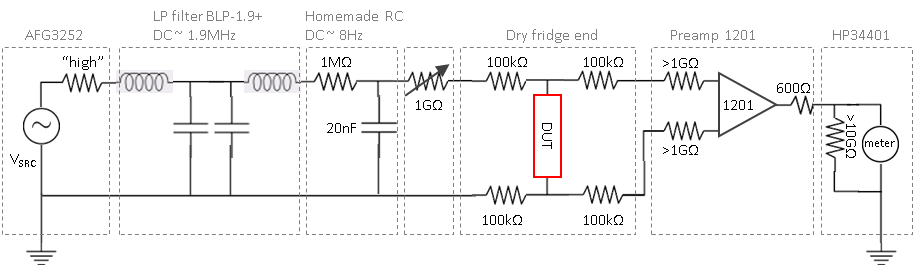

In [5]:
display(Image(filename=r'C:\Users\KelvinOX25\Documents\GitHub\DC meas\img\191026-183349.png'))

## Data acqusition

### IVc measurement at RT

- Q1D055B1N4_RT, R~125k$\Omega$

- Measure at intermediat T during cooldown

## Scripts

### Instrument and QC database initialization

In [290]:
try:
   Instrument.close_all()
except KeyError:
   pass    
except NameError:
   pass 

In [291]:
K2602 =  Keithley_2600(name = 'K2602', address = "GPIB::26::INSTR" )
Flux_chA = K2602.smua.curr
Flux_chB = K2602.smub.curr
Bfield =  Flux_chA

LS370 = Model_372(name = 'LS370 input Ch', address = 'GPIB::12::INSTR', terminator='\n')
T8 = LS370.ch08.temperature

Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR',  R_bias = 1e9, Attn = 1)

Vmeter = HP34401_DL1201('meter', 'GPIB0::8::INSTR', Gain = 100)
Vmeter.init('fast 6')

Connected to: LSCI 370 (serial:370665, firmware:04102008) in 0.11s


In [6]:
SAMPLE = '55B1'

station = qc.Station(Isrc, Vmeter)
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)   
initialise_database()

### Measurement scripts

In [352]:
def setup():
    Isrc.I.set(0) 

def cleanup():
    Isrc.I.set(0) 
    Bfield.set(0)

In [ ]:
def IVC_udu (amp, stp, Gain, R_bias, Attn):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    
    i_list = udu_list(amp, stp)
    ti_list = tqdm_notebook(i_list)

    name_exp(sample = SAMPLE, exp_type = 'udu IVC @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision = 3)))
    with meas.run() as datasaver:
        for i in ti_list:
            
            Isrc.I.set(i)
            time.sleep(0.025)
            V = Vmeter.V.get()

#             Vs.append(V)
            res = [( Isrc.I, i ), ( Vmeter.V, V )]
            datasaver.add_result(*res) 
        dataid = datasaver.run_id 

#     plot_by_id(dataid, marker = 'o', ls = '')  

In [370]:
def Ic_meas (amp, stp, thr, Gain, R_bias, Attn):

    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain (Gain) 
    Isrc.set_R_Attn (R_bias, Attn)
    
    i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
    ti_list_u = tqdm_notebook(i_list_u)
    i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)    
    ti_list_d = tqdm_notebook(i_list_d)
    ti_lists = [ ti_list_u ,  ti_list_d]

#     Vs = []
#     Is = []
    
    name_exp(sample = SAMPLE, exp_type = 'sc branch @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision = 3)))
            
    with meas.run() as datasaver:
        for ti_list in ti_lists:
            
            Isrc.I.set(0)
            V_ = Vmeter.V.get()            
            time.sleep(1)
            
            for i in ti_list:
            
                Isrc.I.set(i)
                time.sleep(0.025)

                V = Vmeter.V.get()
                dV = V - V_
                V_ = V 
#                 print(dV)
                
                if (abs(dV) > thr)  or (abs(V) > 4e-3 ) : #
                    break

#                 Is.append(i)
#                 Vs.append(V)
                res = [( Isrc.I, i ), ( Vmeter.V, V )]
                datasaver.add_result(*res) 
            dataid = datasaver.run_id 
#         plot_by_id(dataid, marker = 'o', ls = '')        
#         print(extract_Isw_R0_by_id (dataid))    

In [ ]:
def IVcB_meas (amp=1e-9, Istp=2e-12, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, B_list = B_list):

    stp = Istp
    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
    # ti_list_u = tqdm_notebook(i_list_u, leave = False)
    i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)
    # ti_list_d = tqdm_notebook(i_list_d, leave = False)
    i_lists = [i_list_u ,  i_list_d]
#     i_lists = udu_list(amp, Istp) for udu meas

    B_list = B_list
#     B_list = np.linspace(0,  Bset,  round (Bset/Bstp) + 1)
#     B_list = [0.260E-3, 1.600E-3]

    meas = set_meas(Vmeter.V, Isrc.I,setup = setup, cleanup = cleanup)
    tB_list = tqdm_notebook(B_list)
    for B in tB_list:

        name_exp(sample = SAMPLE, exp_type = 'full IVc(B) @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision =3)))
        with meas.run() as datasaver:

            Bfield.set(B)
    #         Is, Vs = [], []
            for i_list in i_lists:

                Isrc.I.set(0)
                V_ = Vmeter.V.get()
                time.sleep(1)

                for i in i_list:

                    Isrc.I.set(i)
                    time.sleep(0.025)

                    V = Vmeter.V.get()
                    dV = V - V_
                    V_ = V

                    if  (abs(V) > 8e-3) : #(abs(dV) > thr)  or
                        break

                    res = [( Isrc.I, i ), ( Vmeter.V, V )]
                    datasaver.add_result(*res) 

    #                 Is.append(i)
    #                 Vs.append(V)
    #         Is, Vs = np.array(Is), np.array(Vs) 
    #         print(extract_Isw_R0 (Is, Vs))

            dataid = datasaver.run_id 
    #         plot_by_id(dataid)•

Starting experimental run with id: 48
67 134
(1e-09, nan)
67 134
(1e-09, nan)
67 134
(1e-09, nan)
67 134
(1e-09, nan)
67 134
(1e-09, nan)
67 134
(1e-09, nan)
67 134
(1e-09, nan)
67 134
(1e-09, nan)
67 134
(1e-09, nan)
67 134
(1e-09, nan)
67 134
(1e-09, nan)



<IPython.core.display.Javascript object>


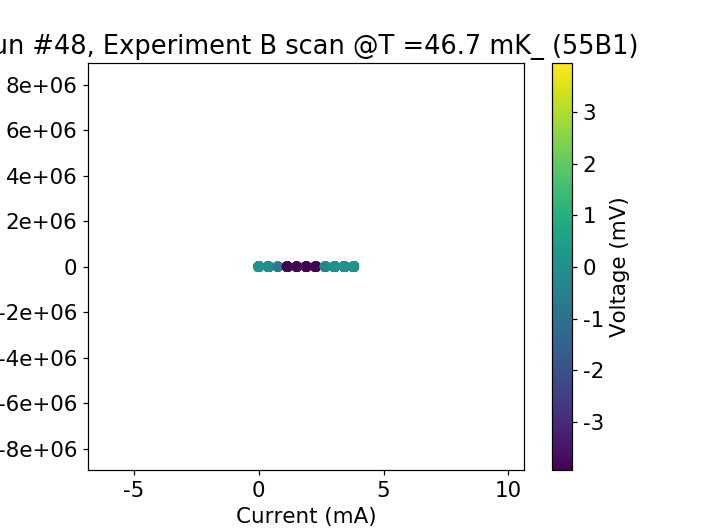

([<matplotlib.axes._subplots.AxesSubplot at 0x1899a8d0>],
 [<matplotlib.colorbar.Colorbar at 0x1459bff0>])

In [381]:
meas = set_meas(Vmeter.V, Isrc.I, Bfield, setup = setup, cleanup = cleanup)

amp = 1e-9
stp = 10e-12

thr = 1e-3

Vmeter.set_Gain (Gain = 100) 
Isrc.set_R_Attn ( R_bias = 1e9, Attn=1 )

i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)

# ti_list_u = tqdm_notebook(i_list_u, leave = False)
# ti_list_d = tqdm_notebook(i_list_d, leave = False)

i_lists = [ i_list_u ,  i_list_d]

B_list = np.linspace(0, 3.8e-3, 11 )

tB_list = tqdm_notebook(B_list)

name_exp(sample = SAMPLE, exp_type = 'B scan @T ={}K'.format(si_format(T8.get())) )  
with meas.run() as datasaver:

    
    for B in tB_list:
        
        Bfield.set(B)
        
        Is, Vs = [], []
        
        
        
        for i_list in i_lists:

            Isrc.I.set(0)
            V_ = Vmeter.V.get()

            time.sleep(1)
            
            exit = False

            for i in i_list:

                
                if not exit:
                    Isrc.I.set(i)
                    time.sleep(0.025)

                    V = Vmeter.V.get()

                    dV = V - V_
                    V_ = V


                    if (abs(dV) > thr)  or (abs(V) > 4e-3 ) : #
#                         break
                        exit = True
                        V = np.nan

                res = [( Isrc.I, i ), ( Vmeter.V, V ), (Bfield, B)]

                datasaver.add_result(*res) 

                Is.append(i)
                Vs.append(V)

        Is, Vs = np.array(Is), np.array(Vs) 
        print(extract_Isw_R0 (Is, Vs))
        
    dataid = datasaver.run_id 



plot_by_id(dataid)


### Data processing scripts

In [330]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
#         print(n_min, n_max)
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

In [337]:
def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [215]:
def databyid (run_id: int, **kwargs):
    from qcodes.dataset.data_set import load_by_id

    dataset = load_by_id(run_id)
    title = f"#{run_id}, Exp {dataset.exp_name} ({dataset.sample_name})"
    alldata = get_data_by_id(run_id)
    
#     x = ['alldata'][0][0]['data']
#     y = ['alldata'][0][1]['data']

    return ({'title':title, 'alldata':alldata})

print(databyid(48)['alldata'][0][2]['name'])

alldata = get_data_by_id(run_id)
fig, ax = plt.subplots()
ax.plot(alldata[0][0]['data'], alldata[0][1]['data'], '.-')

### Measurement plans

**list of run_ids*

#073-173: IVC for T=45mK, Blist = np.linspace(0,2e-3,101), Vthr = 4mV
#174-228: IVC for T=45mK, Blist = np.linspace(0,2e-3,51), Vthr = 8mV
#229,230: Full IVC for T=80mK, Blist = [ZF,FF]
#231,232: Full IVC for T=100mK, Blist = [ZF,FF]
#233,234: Full IVC for T=125mK, Blist = [ZF,FF]
#236,237: Full IVC for T=150mK, Blist = [ZF,FF]
#238,239: Full IVC for T=175mK, Blist = [ZF,FF]
#246-297: IVC for T=200mK, Blist = np.linspace(0e-3, 2e-3, 51), Vthr = 4mV
#300-305: Full IVC for T=200mK, Blist = np.linspace(1e-3, 2e-3, 6), Vthr = 8mV
#306-356: IVC for T=300mK, Blist = np.linspace(0e-3, 2e-3, 51), Vthr = 4mV
#357-359: check full frustration periodicity
#360-410: IVC for T=350mK, Blist = np.linspace(0e-3, 2e-3, 51), Vthr = 4mV
#411-421: Full IVC for T=350mK, Blist = np.linspace(1e-3, 2e-3, 11), Vthr = 8mV
#422-432: Full IVC for T=400mK, Blist = np.linspace(1e-3, 2e-3, 11), Vthr = 8mV



In [156]:


ZF = .22e-3
FF = 1.6e-3

keys  = ['ids',                  'T',          'B',                      'Vthr']



valss = [[range(73 ,173+1),      45e-3,  np.linspace(0,2e-3,101),        4e-3],
         [range(174,228+1),      45e-3,  np.linspace(0,2e-3,51) ,        8e-3],
         [range(229,230+1),      80e-3,  [ZF,FF],                        np.nan],
         [range(231,232+1),     100e-3,  [ZF,FF],                        np.nan],
         [range(233,234+1),     125e-3,  [ZF,FF],                        np.nan],
         [range(236,237+1),     150e-3,  [ZF,FF],                        np.nan],
         [range(238,239+1),     175e-3,  [ZF,FF],                        np.nan],
         [range(246,297+1),     200e-3,  np.linspace(0e-3, 2e-3, 51),    4e-3],
         [range(300,305+1),     200e-3,  np.linspace(1e-3, 2e-3, 6),     8e-3],
         [range(306,356+1),     300e-3,  np.linspace(0e-3, 2e-3, 51),    4e-3],
         [range(360,410+1),     350e-3,  np.linspace(0e-3, 2e-3, 51),    4e-3],
         [range(411,421+1),     350e-3,  np.linspace(0e-3, 2e-3, 11),    8e-3],
         [range(422,432+1),     400e-3,  np.linspace(1e-3, 2e-3, 11),    8e-3]]  
        

exps = [{ key : val for key, val in zip(keys, vals)  }  for vals in valss ]

In [159]:
#that's nice, isnt it? :)

exps[0]

{'ids': range(73, 174),
 'T': 0.045,
 'B': array([0.00e+00, 2.00e-05, 4.00e-05, 6.00e-05, 8.00e-05, 1.00e-04,
        1.20e-04, 1.40e-04, 1.60e-04, 1.80e-04, 2.00e-04, 2.20e-04,
        2.40e-04, 2.60e-04, 2.80e-04, 3.00e-04, 3.20e-04, 3.40e-04,
        3.60e-04, 3.80e-04, 4.00e-04, 4.20e-04, 4.40e-04, 4.60e-04,
        4.80e-04, 5.00e-04, 5.20e-04, 5.40e-04, 5.60e-04, 5.80e-04,
        6.00e-04, 6.20e-04, 6.40e-04, 6.60e-04, 6.80e-04, 7.00e-04,
        7.20e-04, 7.40e-04, 7.60e-04, 7.80e-04, 8.00e-04, 8.20e-04,
        8.40e-04, 8.60e-04, 8.80e-04, 9.00e-04, 9.20e-04, 9.40e-04,
        9.60e-04, 9.80e-04, 1.00e-03, 1.02e-03, 1.04e-03, 1.06e-03,
        1.08e-03, 1.10e-03, 1.12e-03, 1.14e-03, 1.16e-03, 1.18e-03,
        1.20e-03, 1.22e-03, 1.24e-03, 1.26e-03, 1.28e-03, 1.30e-03,
        1.32e-03, 1.34e-03, 1.36e-03, 1.38e-03, 1.40e-03, 1.42e-03,
        1.44e-03, 1.46e-03, 1.48e-03, 1.50e-03, 1.52e-03, 1.54e-03,
        1.56e-03, 1.58e-03, 1.60e-03, 1.62e-03, 1.64e-03, 1.66e-03,
      

**Plan**

Until we find recovery of $I_{SW}$, at each T perform:
- Full IVcB(thr = 8mV) for np.linspace(1e-3, 2e-3, 6)
- IVcB(thr = 4mV) for np.linspace(1e-3, 2e-3, 51)

After we find recovery of $I_{SW}$, at each T perform:
- ZF, FF for Full IVcB(thr = 8mV) [0.260E-3, 1.600E-3, 2.940E-3]

**Selected meas to be done**
- Check Field stability B_list = [0.260E-3, 1.600E-3, 2.940E-3]...
- Check Periodicity B_list = [0.260E-3, 1.600E-3, 2.940E-3]
- Check AWG5204 ramping features, noise level as a source (judging from $I_{SW}$)
- Check Attn. effects as reducing noise level from the source.

**Quick visualization of the results**

In [25]:
from qcodes.dataset.data_set import load_by_id
def labelledplot (run_id, ax, str1, str2):
    dataset = load_by_id(run_id)
    stri = dataset.exp_name.split(str1)[1]
    stri = stri.split(str2)[0]
    plot_by_id(run_id, ax, marker = '.', ls = '-', label=stri)

<IPython.core.display.Javascript object>


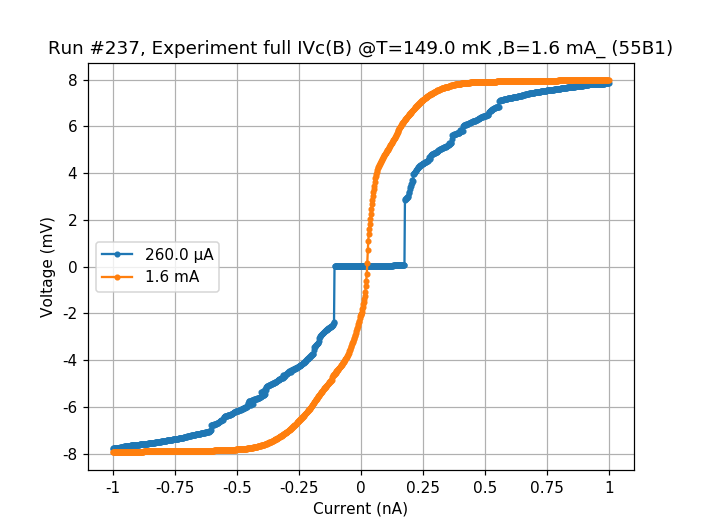

In [137]:
fig, ax = plt.subplots()
labelledplot (236, ax, 'B=', '_')
labelledplot (237, ax, 'B=', '_')

ax.set_ylim(-8.7E-3, 8.7E-3)
ax.set_xlim(-1.1E-9, 1.1E-9)
ax.legend(loc=6)
ax.grid('both')

<IPython.core.display.Javascript object>


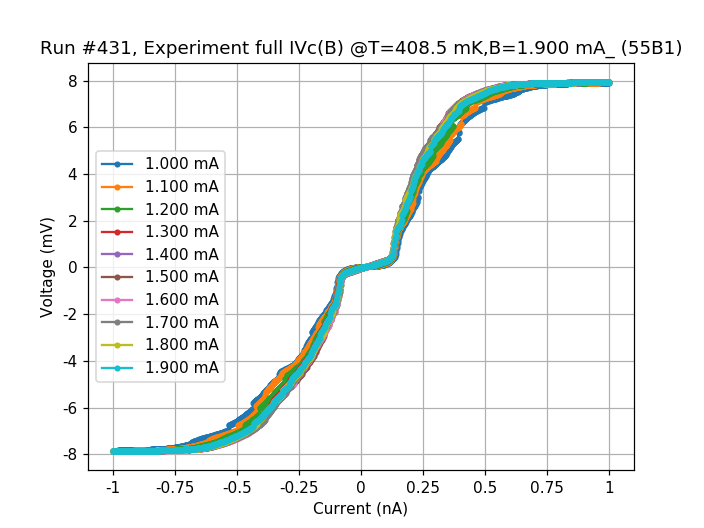

In [ ]:
fig, ax = plt.subplots()
for i in range(10):
    labelledplot (i+422, ax, 'B=', '_')
    
ax.legend(loc=6)
ax.grid('both')

<IPython.core.display.Javascript object>


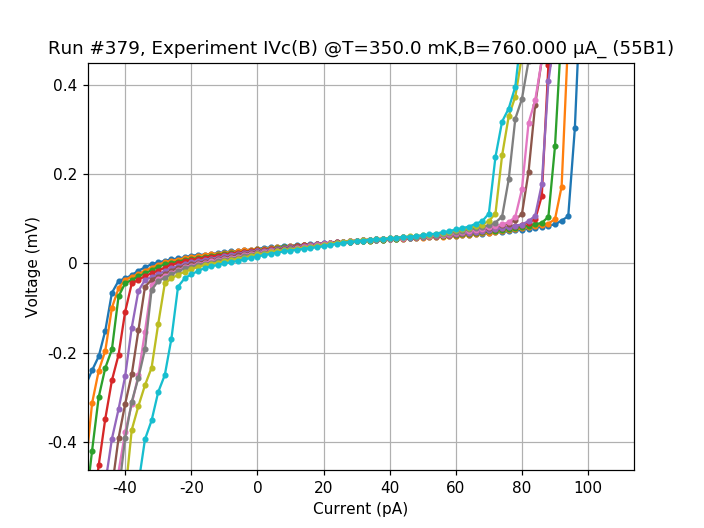

In [76]:
fig, ax = plt.subplots()
for i in range(370,380):
    plot_by_id(i, ax, marker='.', ls='-')
ax.grid('both')

In [155]:
for i in np.arange(150,240):
    dataset = load_by_id(i+1)
    print('id:{}, title:'.format(i+1)+dataset.exp_name)

### Results Summary

<IPython.core.display.Javascript object>


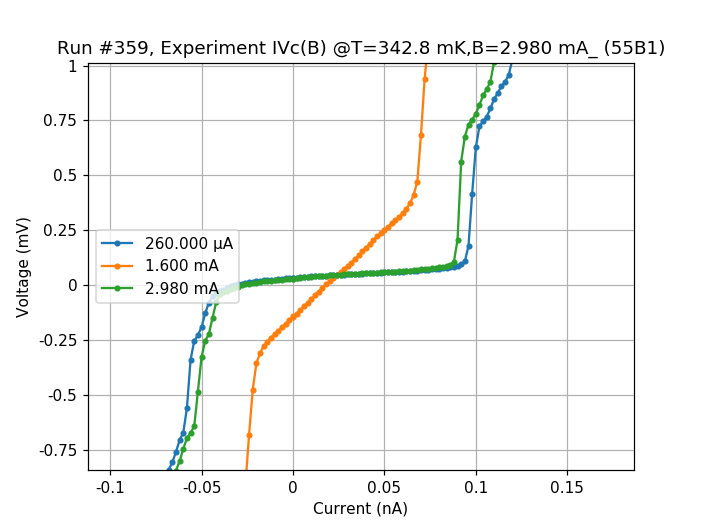

In [68]:
# Check the periodicity
fig, ax = plt.subplots()
labelledplot(357, ax, 'B=', '_')
labelledplot(358, ax, 'B=', '_')
labelledplot(359, ax, 'B=', '_')
    
ax.legend(loc=6)
ax.grid('both')

<IPython.core.display.Javascript object>


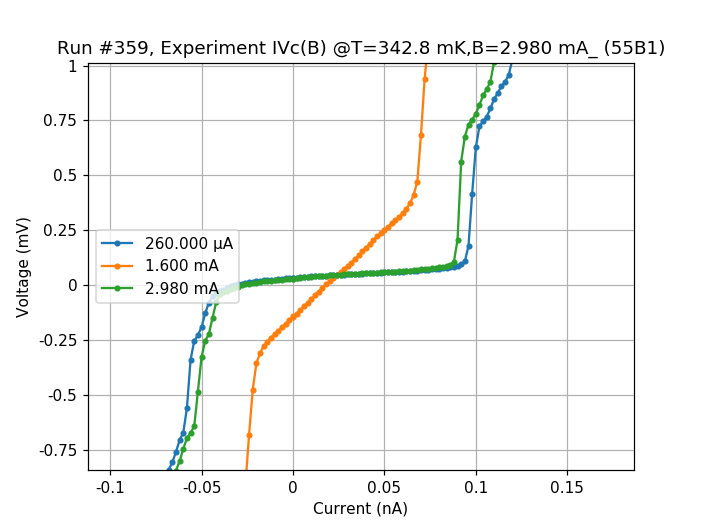

In [68]:
fig, ax = plt.subplots()
for i in range(370,380):
    plot_by_id(i, ax, marker='.', ls='-')
ax.grid('both')


### Experiments log

### Device # at base T

In [ ]:
Flux_chA.step = .1e-3
Flux_chA.inter_delay = .1
Bfield.set(0e-3)
# sourcerange_i'

# IVC_udu (amp = 1e-9, stp = 10e-12, Gain = 100, R_bias = 1e9, Attn = 1)
# Ic_meas (amp = 1e-9, stp = 2e-12, thr = 1e-3, Gain = 100, R_bias = 1e9, Attn = 1)

<IPython.core.display.Javascript object>


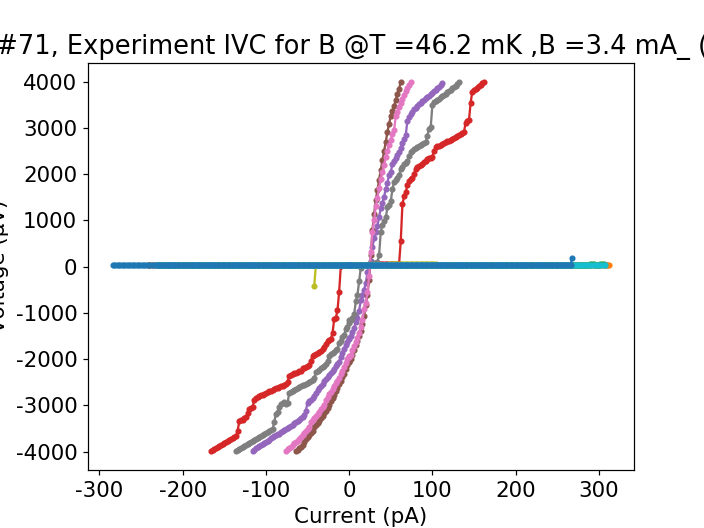

19 38
93 186
89 179
55 110
38 77
21 43
25 51
45 90
25 50
90 181
92 185


In [403]:
Isws = []
R0s = []

fig, ax = plt.subplots()

for i in range(11):
    plot_by_id(61+i, ax, marker = '.', ls = '-')
    
    Isw, R0 = extract_Isw_R0_by_id (61+i)
    Isws.append(Isw)
    R0s.append(R0)   

NameError: name 'plot_by_id' is not defined

<IPython.core.display.Javascript object>


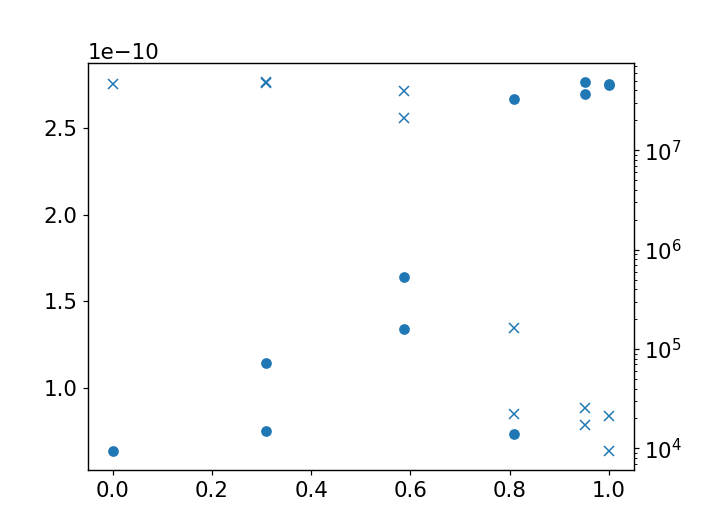

In [409]:
fig, ax = plt.subplots()


cos = abs(np.cos(np.pi*B_list/3.8e-3) )
ax.plot(cos, Isws, 'o')

# ax.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(cos, R0s, 'x')
ax2.set_yscale('log')
